In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
'''
Code for early stopping from https://github.com/Bjarten/early-stopping-pytorch
'''

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            #self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [6]:
# Renaming y of the column by mapping each of the images to its output
# 0 - cavallo
# 1 - elefante
# 2 - farfalla
# 3 - gallina
# 4 - gatto

df1 = pd.read_csv('/content/cavallo.csv', header=None)
df1.rename(columns={0: 'y'}, inplace=True)
df1 = df1.assign(y=0)

df2 = pd.read_csv('/content/elefante.csv', header=None)
df2.rename(columns={0: 'y'}, inplace=True)
df2 = df2.assign(y=1)

df3 = pd.read_csv('/content/farfalla.csv', header=None)
df3.rename(columns={0: 'y'}, inplace=True)
df3 = df3.assign(y=2)

df4 = pd.read_csv('/content/gallina.csv', header=None)
df4.rename(columns={0: 'y'}, inplace=True)
df4 = df4.assign(y=3)

df5 = pd.read_csv('/content/gatto.csv', header=None)
df5.rename(columns={0: 'y'}, inplace=True)
df5 = df5.assign(y=4)

# Cleaning up the dataframe by deleting the last column
df1.drop(df1.columns[len(df1.columns)-1], axis=1, inplace=True)
df2.drop(df2.columns[len(df2.columns)-1], axis=1, inplace=True)
df3.drop(df3.columns[len(df3.columns)-1], axis=1, inplace=True)
df4.drop(df4.columns[len(df4.columns)-1], axis=1, inplace=True)
df5.drop(df5.columns[len(df5.columns)-1], axis=1, inplace=True)

frames = [df1, df2, df3, df4, df5]
df = pd.concat(frames)

In [7]:
X = df.drop(columns = ['y']).copy()
y = df['y']

X = np.array(X)
y = np.array(y)

In [8]:
BATCH_SIZE = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y)
train_dataloader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size = BATCH_SIZE, shuffle = True)

In [9]:
class AANN1(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(48, 40),
            nn.Tanh(),
            nn.Linear(40, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 40),
            nn.Tanh(),
            nn.Linear(40, 48),
        )
          
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Training the first layer of Autoencoder

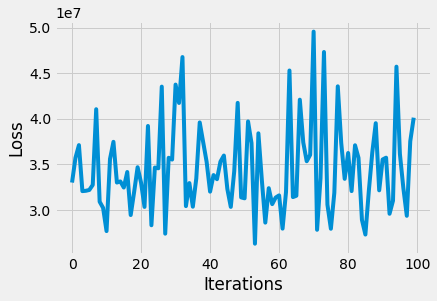

In [13]:
SAE1 = AANN1()
SAE1.to(device)

loss_function = nn.MSELoss(reduction = 'mean')
optimizer = optim.Adam(SAE1.parameters(), lr = 3e-4, weight_decay = 1e-8)
early_stopping = EarlyStopping(patience=20)

epochs = 100
losses = []
avg_test_loss = []
for epoch in range(epochs):
  SAE1.train()
  for (histogram, _) in train_dataloader:      
    # Moving histogram to device memory
    histogram = histogram.type(torch.float32).to(device)
    optimizer.zero_grad()
    # Output of Autoencoder
    reconstructed = SAE1(histogram)
    reconstructed = reconstructed.squeeze()
    # Calculating the loss
    histogram = histogram.squeeze()
    loss = loss_function(reconstructed, histogram)
      
    loss.backward()
    optimizer.step()
      
    # Storing the losses in a list for plotting
    losses.append(loss.detach().cpu().numpy())
  
  test_losses = []
  SAE1.eval() # prep model for evaluation
  for histogram, _ in test_dataloader:
    histogram = histogram.type(torch.float32).to(device)
    reconstructed = SAE1(histogram)
    reconstructed = reconstructed.squeeze()
    # calculate the loss
    loss = loss_function(reconstructed, histogram)
    # record validation loss
    test_losses.append(loss.item())
  
  avg_test_loss.append(np.average(test_losses))
  early_stopping(avg_test_loss[-1], SAE1)
        
  if early_stopping.early_stop:
    print("Early stopping")
    break

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(losses[:100])

## Training the second layer of the autoencoder

In [14]:
class AANN2(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(32, 24),
            nn.Tanh(),
            nn.Linear(24, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 24),
            nn.Tanh(),
            nn.Linear(24, 32)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Early stopping


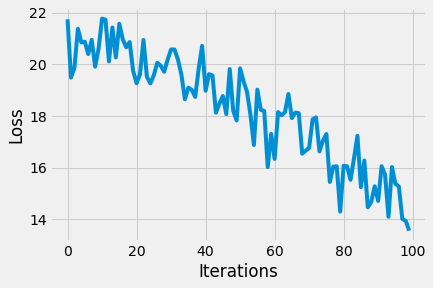

In [18]:
# Freeze the weights of the first stacked encoder
SAE1.eval()
SAE2 = AANN2()
SAE2.to(device)

loss_function = nn.MSELoss(reduction = 'mean')
optimizer = optim.Adam(SAE2.parameters(), lr = 3e-4, weight_decay = 1e-8)

epochs = 100
losses = []
avg_test_loss = []
for epoch in range(epochs):
  SAE2.train()
  for (histogram, _) in train_dataloader:      
    histogram = histogram.type(torch.float32).to(device)
    optimizer.zero_grad()

    # Output of Autoencoder1
    output_intermediate = SAE1.encoder(histogram)
    # Ouptput of Autoencoder 2
    reconstructed = SAE2(output_intermediate)
    reconstructed = reconstructed.squeeze()
    
    # Calculating the loss
    output_intermediate = output_intermediate.squeeze()
    loss = loss_function(reconstructed, output_intermediate)

    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu().numpy())
  
  test_losses = []
  SAE2.eval() # prep model for evaluation
  for histogram, _ in test_dataloader:
    histogram = histogram.type(torch.float32).to(device)
    output_intermediate = SAE1.encoder(histogram)
    reconstructed = SAE2(output_intermediate)
    reconstructed = reconstructed.squeeze()
    # calculate the loss
    loss = loss_function(reconstructed, output_intermediate)
    # record validation loss
    test_losses.append(loss.item())
  
  avg_test_loss.append(np.average(test_losses))
  early_stopping(avg_test_loss[-1], SAE2)
        
  if early_stopping.early_stop:
    print("Early stopping")
    break
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(losses[:100])

## Training the third layer of autoencoder

In [19]:
class AANN3(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(16, 12),
            nn.Tanh(),
            nn.Linear(12, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 12),
            nn.Tanh(),
            nn.Linear(12, 16)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Early stopping


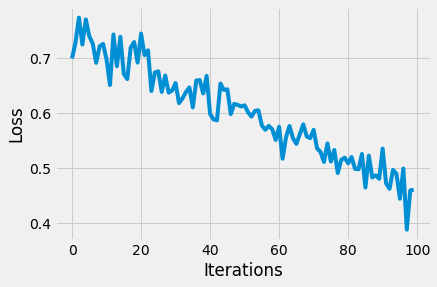

In [21]:
SAE3 = AANN3()
SAE3.to(device)
loss_function = nn.MSELoss(reduction = 'mean')
  
optimizer = optim.Adam(SAE3.parameters(), lr = 3e-4, weight_decay = 1e-8)

epochs = 10
losses = []
avg_test_loss = []
SAE1.eval()
SAE2.eval()
for epoch in range(epochs):
  SAE3.train()
  for (histogram, _) in train_dataloader:
    histogram = histogram.type(torch.float32).to(device)
    optimizer.zero_grad()

    output_1 = SAE1.encoder(histogram)
    output_intermediate = SAE2.encoder(output_1)
    reconstructed = SAE3(output_intermediate)
    reconstructed = reconstructed.squeeze()
    # Calculating the loss
    output_1 = output_1.squeeze()
    loss = loss_function(reconstructed, output_intermediate)
      
    # The gradients are set to zero,
    # the the gradient is computed and stored.
    # .step() performs parameter update
    loss.backward()
    optimizer.step()
      
    # Storing the losses in a list for plotting
    losses.append(loss.detach().cpu().numpy())

  test_losses = []
  SAE3.eval() # prep model for evaluation
  for histogram, _ in test_dataloader:
    histogram = histogram.type(torch.float32).to(device)
    output_1 = SAE1.encoder(histogram)
    output_intermediate = SAE2.encoder(output_1)
    reconstructed = SAE3(output_intermediate)
    reconstructed = reconstructed.squeeze()
    # calculate the loss
    loss = loss_function(reconstructed, output_intermediate)
    # record validation loss
    test_losses.append(loss.item())
  
  avg_test_loss.append(np.average(test_losses))
  early_stopping(avg_test_loss[-1], SAE2)
        
  if early_stopping.early_stop:
    print("Early stopping")
    break
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(losses[:100])

In [22]:
class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        SAE1.train()
        SAE2.train()
        SAE3.train()
        self.ae1 = SAE1.encoder
        self.ae2 = SAE2.encoder
        self.ae3 = SAE3.encoder
        self.DNN = nn.Linear(8, 5)
            
    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)
        output = self.DNN(a3)
        return output

epoch: 0
Train Accuracy:  0.285257508279091
epoch: 1
Train Accuracy:  0.33927143999086445
epoch: 2
Train Accuracy:  0.35365992919949757
epoch: 3
Train Accuracy:  0.36519355943816373
epoch: 4
Train Accuracy:  0.3677058353317346
epoch: 5
Train Accuracy:  0.3755852460888432
epoch: 6
Train Accuracy:  0.36473678200296905
epoch: 7
Train Accuracy:  0.3658787255909558
epoch: 8
Train Accuracy:  0.36793422404933196
epoch: 9
Train Accuracy:  0.36610711430855314
epoch: 10
Train Accuracy:  0.3671348635377412
epoch: 11
Train Accuracy:  0.36245289482699555
epoch: 12
Train Accuracy:  0.3672490578965399
epoch: 13
Train Accuracy:  0.3719310266072856
epoch: 14
Train Accuracy:  0.3738723307068631
epoch: 15
Train Accuracy:  0.3828936850519584
epoch: 16
Train Accuracy:  0.37535685737124586
epoch: 17
Train Accuracy:  0.3766129953180313
epoch: 18
Train Accuracy:  0.3800388260819916
epoch: 19
Train Accuracy:  0.37307297019527236
epoch: 20
Train Accuracy:  0.37501427429484985
epoch: 21
Train Accuracy:  0.370903

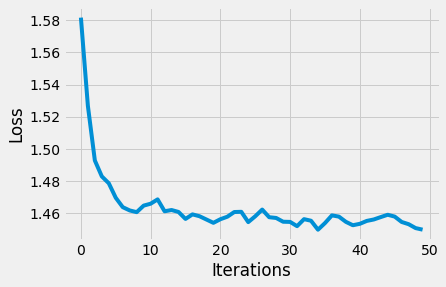

In [23]:
model = StackedAutoEncoder()
model.to(device)
loss_function = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-8)

train_loss_list = list()
epochs = 50
accuracy_metrics = {
  'train': [],
  'test': []
}

for epoch in range(epochs):
    temp_loss_list = list()
    correct_classified = 0
    for x_train, y_train in train_dataloader:
        model.train()
        x_train = x_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.long).to(device)
        optimizer.zero_grad()

        # Output of Autoencoder
        output = model(x_train)
        # Calculating the loss function
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()
        temp_loss_list.append(loss.detach().cpu().numpy())
        max_indices = torch.argmax(output, dim=1)
        correct_classified +=  (max_indices == y_train).float().sum()
          
        # Storing the losses in a list for plotting
    train_loss_list.append(np.average(temp_loss_list))
    accuracy_metrics["train"].append(correct_classified.item() / len(train_dataloader.dataset))
    print("epoch:", epoch)
    print("Train Accuracy: ", correct_classified.item() / len(train_dataloader.dataset))
  
correct_classified = 0
model.eval()
test_loss_list = list()
for X_test, y_test in test_dataloader:
    X_test = X_test.type(torch.float32).to(device)
    y_test = y_test.type(torch.long).to(device)

    score = model(X_test)
    loss = loss_function(input=score, target=y_test)

    test_loss_list.append(loss.detach().cpu().numpy())
    max_indices = torch.argmax(score, dim=1)
    correct_classified +=  (max_indices == y_test).float().sum()

accuracy_metrics["test"].append(correct_classified.item() / len(test_dataloader.dataset))
test_loss_list.append(np.average(test_loss_list))

print("Train average loss: %.5f" %train_loss_list[-1])
print("Test average loss: %.5f" %test_loss_list[-1])
print("Test Accuracy: %.5f" %accuracy_metrics['test'][0])
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(train_loss_list)

